# Robust Linear Regression

This is a linear regression with a Student-T distribution for the error model.

In [1]:
import numpy as np
import scipy

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt

import pystan

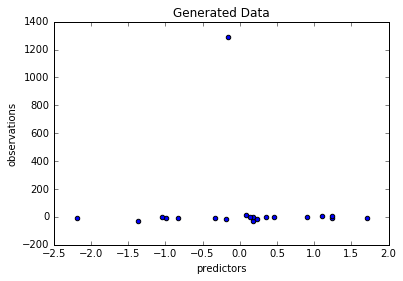

In [2]:
N = 20
predictors = np.random.randn(N)
noise = scipy.stats.t.rvs(df=1, size=N, scale=4.0)
observations = 2.0 * predictors - 1.5 + noise

fig, ax = plt.subplots(1,1)
ax.set_title('Generated Data')
ax.set_xlabel('predictors')
ax.set_ylabel('observations')
ax.scatter(predictors, observations)
fig.show()

In [3]:
import pystan

In [4]:
model_code = """
data {
    real<lower=0> alpha_sigma;
    real<lower=0> beta_sigma;
    real<lower=0> sigma_sigma;

    real<lower=0> nu;

    int N;
    vector[N] x;
    vector[N] y;
}

parameters {
    real beta;
    real alpha;
    real<lower=0> sigma;
}

model {
    alpha ~ cauchy(0, alpha_sigma);
    beta  ~ cauchy(0, beta_sigma);
    sigma ~ cauchy(0, sigma_sigma);
    
    y ~ student_t(nu, beta * x + alpha, sigma);
}
"""
model = pystan.StanModel(model_code=model_code)

In [5]:
fit = model.sampling(data=dict(nu=1, N=N, x=predictors, y=observations, alpha_sigma=10, beta_sigma=10, sigma_sigma=10))
print fit

Inference for Stan model: anon_model_844359b2be33a9a3d86dd3979ff6531d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta     2.2    0.07    1.9  -1.22   0.95   2.11   3.35   6.21  836.0    1.0
alpha  -4.02    0.06    1.7   -7.7  -5.03  -3.93  -2.89  -0.88  836.0    1.0
sigma   5.28    0.06   1.84   2.59   3.97   5.02   6.23   9.56  959.0    1.0
lp__  -61.97    0.05   1.43 -65.71 -62.57 -61.59 -60.95  -60.4  685.0    1.0

Samples were drawn using NUTS(diag_e) at Thu Mar  3 16:30:35 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [6]:
samples = fit.extract()
alpha = samples['alpha'][:, np.newaxis]
beta  = samples['beta'][:, np.newaxis]
mx  = np.linspace(-3, 3)
yxx = np.outer(beta, mx) + alpha

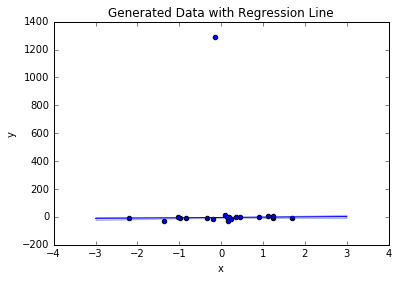

In [7]:
ymed = np.percentile(yxx,   50, axis=0)
ymin = np.percentile(yxx,  2.5, axis=0)
ymax = np.percentile(yxx, 97.5, axis=0)

fig, ax = plt.subplots(1, 1)
ax.set_title('Generated Data with Regression Line')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.scatter(predictors, observations)
reg_line = ax.plot(mx, ymed)
cred_region = ax.fill_between(mx, ymin, ymax, alpha=0.2)
fig.show()